In [ ]:
# google drive နဲ့ ချိတ်ဖို့ပါ
from google.colab import drive
 
drive.mount("/content/gdrive/")

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [ ]:
# training and testing directory
# မိမိရဲ့ ပတ်လမ်းကြောင်း ပြောင်းဖို့ မမေ့ပါနဲ့
train_dir  = '/content/gdrive/MyDrive/Final_dataset/train'
test_dir = '/content/gdrive/MyDrive/Final_dataset/test'

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
rows=160  #Number of Pixels in the Rows for Input. 
cols=160  #Number of Pixels in Columns for Output

In [ ]:
trained_model=MobileNetV2(input_shape=(rows,cols,3),           
                    include_top=False,
                    weights='imagenet')   


trained_model.trainable=True  #Un-Freeze all the pretrained layers of 'MobileNetV2 for Training.
    
trained_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 80, 80, 32)   864         input_3[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 80, 80, 32)   128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 80, 80, 32)   0           bn_Conv1[0][0]                   
_______________________________________________________________________________

In [ ]:
print(trained_model.input)

KerasTensor(type_spec=TensorSpec(shape=(None, 160, 160, 3), dtype=tf.float32, name='input_3'), name='input_3', description="created by layer 'input_3'")


In [ ]:
last_layer=trained_model.get_layer('out_relu')   
last_layer_output=last_layer.output  #Saves the output of the last layer of the MobileNetV2.
print(last_layer_output)

KerasTensor(type_spec=TensorSpec(shape=(None, 5, 5, 1280), dtype=tf.float32, name=None), name='out_relu/Relu6:0', description="created by layer 'out_relu'")


In [ ]:
#Callback Function which stops training when accuracy reaches 98%.
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy') > 0.98):
      print("\nReached 98% accuracy so cancelling training!")
      self.model.stop_training = True
callbacks=myCallback()

In [ ]:
x = tf.keras.layers.GlobalAveragePooling2D()(last_layer_output)
#Add a Dropout layer.
x = tf.keras.layers.Dropout(0.8)(x)                      
# Add a final softmax layer for classification.
x = tf.keras.layers.Dense(4,activation='softmax')(x)

model = tf.keras.Model(trained_model.input,x) 

model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])
#Summary of the model.
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 80, 80, 32)   864         input_3[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 80, 80, 32)   128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 80, 80, 32)   0           bn_Conv1[0][0]                   
____________________________________________________________________________________________

In [ ]:
train_datagen = ImageDataGenerator(rescale=1/255,
                                 shear_range=0.2,
                                 zoom_range=0.2,
                                 horizontal_flip=True,
                                 rotation_range=40,
                                 width_shift_range=0.1,
                                 height_shift_range=0.1)
                                 
test_datagen = ImageDataGenerator(rescale=1/255)

train_generator=train_datagen.flow_from_directory(train_dir,
                                                  target_size=(rows,cols),
                                                  class_mode='categorical')

test_generator=test_datagen.flow_from_directory(test_dir,
                                                target_size=(rows,cols),
                                                class_mode='categorical')

Found 520 images belonging to 4 classes.
Found 80 images belonging to 4 classes.


In [ ]:
result=model.fit(train_generator,
                 validation_data=test_generator,
                 epochs=50,
                 callbacks=[callbacks],
                 verbose=1)

Epoch 1/50
17/17 [==============================] - 63s 3s/step - loss: 2.1918 - accuracy: 0.3154 - val_loss: 1.3652 - val_accuracy: 0.4375
Epoch 2/50
17/17 [==============================] - 56s 3s/step - loss: 1.4307 - accuracy: 0.5096 - val_loss: 1.4437 - val_accuracy: 0.3875
Epoch 3/50
17/17 [==============================] - 57s 3s/step - loss: 1.0214 - accuracy: 0.6173 - val_loss: 1.5189 - val_accuracy: 0.4000
Epoch 4/50
17/17 [==============================] - 55s 3s/step - loss: 0.7230 - accuracy: 0.7192 - val_loss: 1.3895 - val_accuracy: 0.4375
Epoch 5/50
17/17 [==============================] - 55s 3s/step - loss: 0.5651 - accuracy: 0.7731 - val_loss: 1.2786 - val_accuracy: 0.5125
Epoch 6/50
17/17 [==============================] - 55s 3s/step - loss: 0.4300 - accuracy: 0.8346 - val_loss: 1.1881 - val_accuracy: 0.5750
Epoch 7/50
17/17 [==============================] - 57s 3s/step - loss: 0.3370 - accuracy: 0.8769 - val_loss: 1.0460 - val_accuracy: 0.6250
Epoch 8/50
17/17 [==

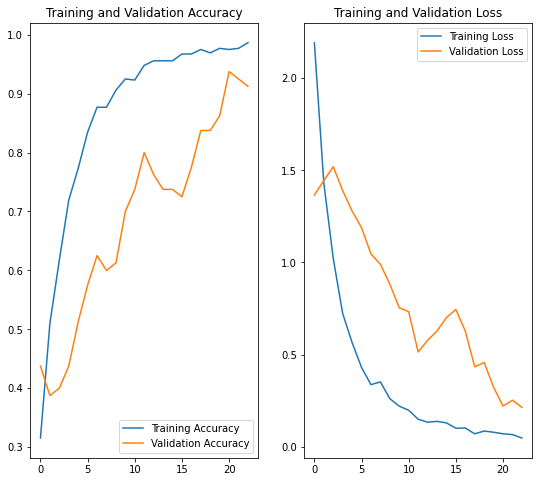

In [ ]:
import matplotlib.pyplot as plt

acc = result.history['accuracy']
val_acc = result.history['val_accuracy']

loss = result.history['loss']
val_loss = result.history['val_loss']

epochs_range = range(23)

plt.figure(figsize=(9, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
classes = model.predict(test_generator)

In [ ]:
import os
import numpy as np

folder_names = ['daw_su','jackie_chan','messi','obama']
y_pred = []
for folder in folder_names:
    path = test_dir+"/"+folder
    path_fnames = os.listdir(path)
    for i in path_fnames:
        path2 = path+'/'+i
        img = tf.keras.preprocessing.image.load_img(path2, target_size=(rows,cols))#target size ကို သတိထားပါ
        x = tf.keras.preprocessing.image.img_to_array(img)
        x = np.expand_dims(x,axis=0)
        x /= 255.0
        images = np.vstack([x])# [1 2 3 4 5 6]
        classes = model.predict(x)
        y_classes=classes.argmax(axis=-1)
        y_pred.append(y_classes[0])
    print()

In [ ]:
# Actual Labels
y_true = test_generator.classes.tolist()
print(len(y_true))

80


In [ ]:
# Class Labels
class_dictionary = test_generator.class_indices
print('Labels dictionary',class_dictionary)

Labels dictionary {'daw_su': 0, 'jackie_chan': 1, 'messi': 2, 'obama': 3}


In [ ]:
#Confusion Matrix
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_true,y_pred)
print('confusion_matrix')
print(confusion_matrix)

confusion_matrix
[[17  0  3  0]
 [ 0 17  3  0]
 [ 0  0 20  0]
 [ 0  0  1 19]]


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, f1_score, recall_score

print('Accuracy Score',accuracy_score(y_true, y_pred)*100,'%')
print('Precision Macro Score',precision_score(y_true, y_pred,average = 'macro')*100,'%')
print('F1 Score',f1_score(y_true, y_pred,average = 'macro')*100,'%')
print('Recall_Score',recall_score(y_true, y_pred, average = 'macro')*100,'%')

Accuracy Score 91.25 %
Precision Macro Score 93.5185185185185 %
F1 Score 92.37 %
Recall_Score 91.25000000000001 %


In [ ]:
import numpy as np
path="/content/gdrive/MyDrive/Final_dataset/test/obama/BO125.jpg"  #Path to the target image to be predicted. 

classes=train_generator.class_indices
class_names=list(classes.keys())   #List of the class names
img = tf.keras.preprocessing.image.load_img(
    path, target_size=(rows, cols)
)

img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch
img_array=img_array/255.

score = model.predict(img_array)

print(
    "The Person in the Image is {} ."
    .format(class_names[np.argmax(score)][:].title())
)

The Person in the Image is Obama .


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


In [ ]:
import logging, os
logging.disable(logging.WARNING)
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"
import tensorflow as tf

In [ ]:
model.save('model_face_new_3.h5')

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
